# Introduction

* Our software package, *ad-AHJZ*, computes gradients by leveraging the technique of automatic differentiation. Before we can understand automatic differentiation, we must first describe and motivate the importance of differentiation itself. Derivatives are vital to quantifying the change that’s occurring over a relationship between multiple factors. Finding the derivative of a function measures the sensitivity to change of a function value with respect to a change in its input argument. Derivatives generalize across multiple scenarios and are well defined for both scalar inputs and outputs, as well as vector inputs and outputs. Derivatives are not only essential in calculus applications like numerically solving differential equations and optimizing and solving linear systems, but are useful in many real world, scientific settings. For example, in finance they help analyze the change regarding the profit/loss for a business or can be used to find the minimum amount of material to construct a new building. In physics, they help calculate the speed and distance of a moving object. In machine learning, derivatives are a fundamental part in optimization techniques to train complex algorithms. Across many domains, derivatives are crucial to understanding how such relationships move and change.



* To perform differentiation, two different approaches are solving the task symbolically or numerically computing the derivatives. Symbolic differentiation yields accurate answers, however depending on the complexity of the function, it could be expensive to evaluate and result in inefficient code. On the other hand, numerically computing derivatives is less expensive, however it suffers from potential issues with numerical stability and a loss of accuracy.   


* Our software package, *ad-AHJZ*, overcomes the shortcomings of both the symbolic and numerical approach. Our package uses automatic differentiation which is less costly than symbolic differentiation, but evaluates derivatives at machine precision. The technique leverages both forward mode and backward mode and evaluates each step with the results of previous computations or values. As a result of this, automatic differentiation avoids finding the entire analytical expression to compute the derivative and is hence iteratively evaluating a gradient based on input values. Thus, based on these key advantages, our library implements and performs forward mode automatic differentiation to efficiently and accurately compute derivatives. 


* In order to demonstrate a practical application of forward mode automatic differentiation, our software package implements six optimization techniques. Efficiently finding the minimum value of complex functions is important in solving optimization problems and training machine learning models. A key part in performing such computational work is the computation of a derivative, which can be efficiently done through the use of automatic differentiation. More generally, finding the minimum of a function is relevant to many real-world applications and is especially useful in the field of convex optimization where convexity yields desirable properties of global minima being equivalent to local minima. In light of this broad-reaching impact in the areas of machine learning and optimization, our library implements Momentum, ADAM, NADAM, RMSprop, Broyden, and BFGS optimization techniques. 

# Background

## Automatic Differentiation

#### Part 1: Chain Rule

The underlying motivation of automatic differentiation is the Chain Rule that enables us to decompose a complex derivative into a set of derivatives involving elementary functions of which we know explicit forms. 

We will first introduce the case of 1-D input and generalize it to multidimensional inputs.

*One-dimensional (scalar) Input*: Suppose we have a function $ f(y(t)) $ and we want to compute the derivative of $ f $ with respect to $ t $. This derivative is given by:

$$
\begin{align}
\frac{\partial f}{\partial t} = \frac{\partial f}{\partial y} \frac{\partial y}{\partial t}\\
\end{align}
$$

Before introducing vector inputs, let's first take a look at the gradient operator $ \nabla $

That is, for  $ y\colon \mathbb {R} ^{n} \to \mathbb {R} $, its gradient $ \nabla y \colon \mathbb {R} ^{n} \to \mathbb {R} ^{n}$ is defined at the point $ x = (x_1, ..., x_n) $ in n-dimensional space as the vector:

$$
\begin{align}
\nabla y(x) =
\begin{bmatrix}
{\frac {\partial y}{\partial x_{1}}}(x)
\\
\vdots 
\\
{\frac {\partial y}{\partial x_{n}}}(x)
\end{bmatrix}
\end{align}
$$

*Multi-dimensional (vector) Inputs*: Suppose we have a function $ f(y_1(x), ..., y_n(x)) $ and we want to compute the derivative of $ f $ with respect to $ x $. This derivative is given by:

$$
\begin{align}
\nabla f_x = \sum_{i=1}^n \frac{\partial f}{\partial y_i} \nabla y_i(x)\\
\end{align}
$$

We will introduce direction vector $ p $ later to retrieve the derivative with respect to each $ y_i $. 

#### Part 2: Jacobian-vector Product

The Jacobian-vector product is equivalent to the tangent trace in direction $ p $ if we input the same direction vector $p$:

$ D_p v $ = $ J p $ 

#### Part 3: Seed Vector

Seed vectors provide an efficient way to retrieve every element in a Jacobian matrix and also recover the full Jacobian in high dimensions.

*Scenario:* Seed vectors often come into play when we want to find $ \frac {\partial f_i} {\partial x_j} $, which corresponds to the $i, j$ element of the Jacobian matrix. 

*Motivation:* The seed vector is a user defined parameter that keeps track of derivatives with respect to each independent variable.


#### Part 4: Evaluation (Forward) Trace

*Definition*: Suppose x = $ \begin{bmatrix} {x_1} \\ \vdots \\ {x_m} \end{bmatrix} $, we defined $ v_{k - m} = x_k $ for $ k = 1, 2, ..., m $ in the evaluation trace.

*Motivation*: The evaluation trace introduces intermediate results $ v_{k-m} $ of elementary operations to track the differentiation.

Consider the function $ f(x):\mathbb{R}^2 \to \mathbb{R} $:

$ f(x) = log(x_1) + sin(x_1 + x_2) $

We want to evaluate the gradient $ \nabla f $ at the point $ x = \begin{bmatrix} 7 \\ 4 \end{bmatrix} $. Computing the gradient manually: 

$ \nabla f = \begin{bmatrix} \frac {\partial f} {\partial x_1} \\ \frac {\partial f} {\partial x_2} \end{bmatrix}  = \begin{bmatrix} \frac {1} {x_1} + \cos(x_1 + x_2) \\ \cos(x_1 + x_2) \end{bmatrix} = \begin{bmatrix} \frac {1} {7} + \cos(11) \\  \cos(11) \end{bmatrix}$

| Forward primal trace | Forward tangent trace | Pass with p = $[0, 1]^T$ | Pass with p = $[1, 0]^T$ |
| --- | --- | --- | --- |
| $v_{-1} = x_1$ | $ p_1 $ | 1 | 0 |
| $v_{0} = x_2$ | $ p_2 $ | 0 | 1 |
| $v_{1} = v_{-1} + v_0$ | $ D_p v_{-1} + D_p v_0 $ | 1 | 1 |
| $v_{2} = sin(v_1)$ | $ \cos(v_1) D_p v_1 $ | $ \cos(11) $ | $ \cos(11) $ |
| $v_{3} = log(v_{-1})$ | $ \frac {1} {v_{-1}} D_p v_{-1} $ | $ \frac {1} {7} $ | 0 |
| $v_{4} = v_3 + v_2 $ | $ D_p v_{3} + D_p v_2 $ | $ \frac {1} {7} + \cos(11) $ | $ \cos(11) $ |

$D_p v_{-1} = \nabla v_{-1}^T p = (\frac {\partial v_{-1}} {\partial x_1} \nabla x_{1})^T p = (\nabla x_{1})^T p = p_1$

$D_p v_{0} = \nabla v_{0}^T p = (\frac {\partial v_{0}} {\partial x_2} \nabla x_{2})^T p = (\nabla x_{2})^T p = p_2$

$D_p v_{1} = \nabla v_{1}^T p = (\frac {\partial v_{1}} {\partial v_{-1}} \nabla v_{-1} + \frac {\partial v_{1}}{\partial v_{0}} \nabla v_{0})^T p = (\nabla v_{-1} + \nabla v_0)^T p = D_p v_{-1} + D_p v_0$

$D_p v_{2} = \nabla v_{2}^T p = (\frac {\partial v_{2}} {\partial v_{1}} \nabla v_1)^T p = \cos(v_1) (\nabla v_1)^T p = \cos(v_1) D_p v_1$

$D_p v_{3} = \nabla v_{3}^T p = (\frac {\partial v_{3}} {\partial v_{-1}} \nabla v_{-1})^T p = \frac {1} {v_{-1}} (\nabla v_{-1})^T p = \frac {1} {v_{-1}} D_p v_{-1}$

$D_p v_{4} = \nabla v_{4}^T p = (\frac {\partial v_{4}} {\partial v_3} \nabla v_{3} + \frac {\partial v_{4}}{\partial v_{2}} \nabla v_{2})^T p = (\nabla v_{3} + \nabla v_2)^T p = D_p v_{3} + D_p v_2$

#### Part 5: Computation (Forward) Graph

We have connected each $ v_{k-m} $ to a node in a graph for a visualization of the ordering of operations.

From the above example, its computational graph is given by: 

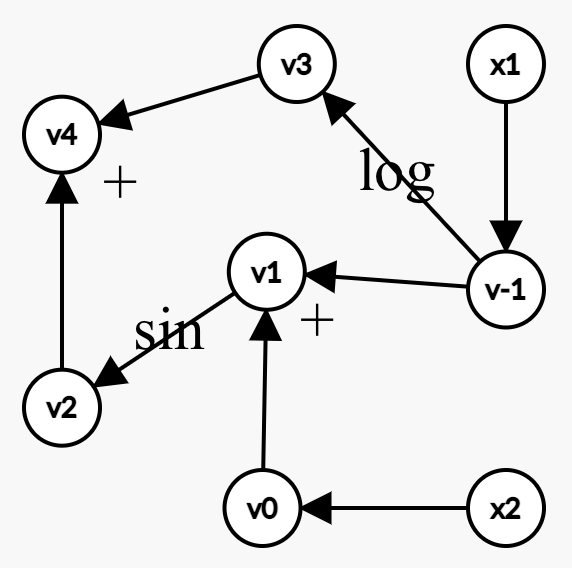

#### Part 6: Computing the Derivative 

Let's generalize our findings:

From the table, we retrieved a pattern as below:

$$ D_p v_j = (\nabla v_j)^T p = (\sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} \nabla v_i)^T p = \sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} (\nabla v_i)^T p = \sum_{i < j} \frac{\partial{v_j}} {\partial{v_i}} D_p v_i$$ 

*Higher dimension*: We recursively apply the same technique introduced above to each entry of the vector valued function *f*.


#### Part 7: Efficiency of Forward Mode 

Forward mode is efficient in the sense that it does not need to store the parent node, which is different from reverse mode (see below) where the whole computational graph must be stored.

#### Part 8: Reverse Mode
The mechanism of reverse mode is defined as the following:

*Step 1:* Calculate $ \frac {\partial f} {\partial v_j} $

*Step 2:* Calculate $ \frac {\partial v_{j}} {\partial v_i} $ where $ v_i $ is the immediate predecessor of $ v_j $

*Step 3:* Multiply the result obtained in step 1 and step 2, which results in the following:
$ \frac {\partial f} {\partial v_j} \frac {\partial v_{j}} {\partial v_i} $

#### Part 9: Dual Number 

*Naively*: We define a dual number $ d_i = v_i + \delta_i $ where $ \delta_i = D_p v_i \epsilon $ that satisfies $ \epsilon^2 = 0 $ 

A $ k $-th differentiable function $ f $ can be written as:

$ f(d_i) = f(v_i + \delta_i) = f(v_i) + f'(v_i) \delta_i + \frac {f''(v_i)} {2!} \delta_i^2 + ... + \frac {{{f}^k}(v_i)} {k!} (\zeta - v_i)^k $ for some $ \zeta \in (v_i, v_i + \delta_i) $ by Taylor expansion. 

Now we substitute the definition of $ \delta_i $ back into the above expansion and use the fact that all higher terms go to 0 assuming $ \epsilon^2 = 0 $. We will have the following:

$ f(d_i) = f(v_i) + f'(v_i) D_p v_i \epsilon $

*Advantage*: Operations on Dual Number pertain to the form of Taylor expansion, which makes the implementation easier to retrieve the value and derivative.

Consider the following example:
$$
\begin{align}
d_i &= v_i + D_p v_i \epsilon \\ 
f(d_i) &= d_i^2 = v_i^2 + 2 v_i D_p v_i \epsilon + D_p v_i^2 \epsilon^2 = v_i^2 + 2 v_i D_p v_i \epsilon \\
\end{align}
$$

where $ v_i^2 $ refers to the value and $ 2 v_i D_p v_i $ refers to the derivative.

More specifically, $ v_i^2 $ corresponds to $ f(v_i) $, $ 2 v_i $ corresponds to $ f'(v_i) $, and $ D_p v_i $ is just $ D_p v_i $.


## Optimization Techniques

Optimization refers to the process of finding the input parameters or arguments to a function that result in the minimum or maximum output of the function. In our package, we only implement the minimization of functions. The most common type of optimization problems encountered in scientific computing are those involving continuous functions. There are various different types of optimization algorithms that can be used for continuous function optimization problems. One common class of optimization algorithms are first-order algorithms, which involve using the first-derivative (gradient) to choose what direction to move in the given search space. This general procedure involves first calculating the gradient of the function, then following the gradient in the opposite direction using a step size to find the optimal point. Popular first-order algorithms include momentum, RMSprop, ADAM, and NADAM. Another common class of optimization algorithms are second-order algorithms. The general procedure behind these algorithms is similar to that of first-order algorithms, however the key difference is that now the second derivative (Hessian) is used instead of the first derivative (gradient) to choose what direction to move in the given search space in order to find the optimal point. Two popular second-order algorithms are BFGS and Broyden. 

The following subsections outline each of the specific first-order and second-order algorithms highlighted above. The mathematical foundation behind the six optimizers and mathematical update rules are based on an [overview](https://ruder.io/optimizing-gradient-descent/index.html#adam) of gradient descent optimization techniques.

#### Part 1: Momentum

Momentum is an optimization method that helps accelerate gradient vectors in the right directions and overcome the oscillations of noisy gradients in order to achieve faster convergence. This is done by adding a fraction $\lambda$ of the update vector of the past time step to the current update vector as follows:

$$v_t = \gamma v_{t-1} + \eta \nabla_\theta J( \theta)$$
$$\theta = \theta - v_t$$

Note that the momentum term $\lambda$ is typically set to a value of 0.9 by default. This momentum term increases for dimensions whose gradients point in the same directions and reduces for dimensions whose gradients change directions. This ultimately leads to faster convergence and reduced oscillation.

#### Part 2: ADAM

Adam (short for Adaptive Moment Estimation) is an optimization method that computes adaptive learning rates for each parameter. This method stores both an exponentially decaying average of past squared gradients $v_{t}$ and an exponentially decaying average of past gradients $m_{t}$. These are both computed as follows:

$$m_{t} = \beta_{1}m_{t-1} + (1-\beta_{1})g_{t}$$
$$v_{t} = \beta_{2}v_{t-1} + (1-\beta_{2})g_{t}^{2}$$

Note that $m_{t}$ is an estimate of the first moment of the gradient (the mean) and $v_{t}$ is an estimate of the second moment of the gradient (the uncentered variance). When initialized with zero vectors, the estimates of $m_{t}$ and $v_{t}$ are biased towards zero, especially during the initial time steps and when the decay rates $\beta_{1}$ and $\beta_{2}$ are small. These biases are counteracted with the following bias-corrected first and second moment estimates:

$$\hat{m_{t}} = \frac{m_{t}}{1-\beta^{t}_{1}}$$
$$\hat{v_{t}} = \frac{v_{t}}{1-\beta^{t}_{2}}$$

These estimates are then used to update the parameters, which yields the following Adam update rule:
$$\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$
The accepted default values for Adam are as follows:
$$\beta_{1} = 0.9$$ 
$$\beta_{2} = 0.999$$ 
$$\epsilon = 10^{-8}$$

#### Part 3: NADAM

Nadam (short for Nesterov-accelerated Adaptive Moment Estimation) is an optimization method that combines Adam and another popular optimizer, NAG. Incorporating NAG into Adam requires modification of its momentum term $m_{t}$. Adding Nesterov momentum to Adam involves replacing the previous momentum vector with the current momentum vector. Recall the Adam update rule defined in the previous section:

$$m_{t} = \beta_{1}m_{t-1} + (1-\beta_{1})g_{t}$$
$$\hat{m_{t}} = \frac{m_{t}}{1-\beta^{t}_{1}}$$
$$\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

Expansion of the update rule with the definitions of $m_{t}$ and $\hat{m_{t}}$ gives us the following:

$$\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} (\dfrac{\beta_1 m_{t-1}}{1 - \beta^t_1} + \dfrac{(1 - \beta_1) g_t}{1 - \beta^t_1})$$

Notice that the term $\dfrac{\beta_1 m_{t-1}}{1 - \beta^t_1}$ is the bias-corrected estimate of the momentum vector, $m_{t-1}$ of the previous time step; therefore, we can substitute as follows:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} (\beta_1 \hat{m}_{t-1} + \dfrac{(1 - \beta_1) g_t}{1 - \beta^t_1})$$

This equation looks very similar to the expanded momentum update rule defined above. In order to add Nesterov momentum, we simply replace the bias-corrected estimate of the momentum vector of the previous time step $\hat{m_{t-1}}$ with the bias-corrected estimate for the momentum vector of the current time step $\hat{m_{t}}$. This leads to the Nadam update rule, which is defined as follows:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} (\beta_1 \hat{m}_t + \dfrac{(1 - \beta_1) g_t}{1 - \beta^t_1})$$ 

#### Part 4:  RMSprop

RMSprop (short for Root Mean Squared Propogation) is another gradient descent optimization algorithm that uses a decaying average of partial gradients in the adaptation of the step size for each parameter. Instead of inefficiently storing all previous squared gradients, the sum of squared gradients is recursively defined as a decaying average of all past squared gradients. The running average $E[g^2]_t$ at time step $t$ thus only depends on the previous average and the current gradient: 

$$E[g^2]_t = 0.9 E[g^2]_{t-1} + 0.1 g^2_t$$

This leads to the following update rule for RMSprop:

$$\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t}$$

Note that the suggested default value for the learning rate $\eta$ is 0.01.

#### Part 5: Broyden

Broyden's method is a secant method for solving systems of nonlinear equations. The key feature of Broyden's method is its ability to generate a reasonable approximation to the Jacobian matrix with no additional evaluations of the function. Let $B_{k}$ be the Jacobian approximation at iteration $k$. Let $s_k = x_{k+1} - x_k$. It follows that the updates Jacobian approximation $B_{k+1}$ must statisfy the following secant equation:

$$ B_{k+1} s_k = f(x_{k+1}) - f(x_k)$$

Given an initial matrix $B_{0}$, Broyden's method generates subsequent matrices using the following update rule:

$$B_{k+1} = B_k + \frac{(y_k - B_k s_k)s_k^T} {\|s_k\|_2^2 }$$

Note that $y_k = f(x_{k+1}) - f(x_k)$.

#### Part 6: BFGS

BFGS (short for Bryoden, Fletcher, Goldfarb, and Shanno) is an iterative second order optimization algorithm that determines the descent direction by preconditioning the gradient with curvature information. This is done by gradually improving an approximation to the Hessian matrix of the loss function, which is obtained via gradient evaluations using a generalized secant method. Given an initial guess $x_{0}$ and an approximate Hessian matrix $B_{0}$, BFGS first obtains a direction $p_{k}$ by solving the equation $B_{k}p_{k} = -\nabla f(x_{k})$. Using this direction, BFGS then requires performing a one-dimensional optimization to find an acceptable step size $\alpha_{k}$ in the desired direction where $\alpha_{k} = \text{argmin} f(x_{k} + \alpha p_{k})$. The algorithm then requires setting $s_{k} = \alpha_{k}p_{k}$ and updating the following:

$$x_{k+1} = x_{k} + s_{k}$$
$$y_{k} = \nabla f(x_{k+1}) -  \nabla f(x_{k})$$
$$B_{k+1} = B_{k} + \frac{y_{k}y_{k}^{T}}{y_{k}^{T}s_{k}} - \frac{B_{k}s_{k}s_{k}^{T}B_{k}^{T}}{s_{k}^{T}B_{k}s_{k}} $$

# How to Use ad-AHJZ

#### 1. __Installing the package:__

We note that we have two options for installing our package. The first option (1a. below) is to download the package from our GitHub repository. The second option (1b-i and 1b-ii. below) is to install the package from PyPI.

* 1a. (Option 1 for installation) User can download the package via our GitHub repository: 

```bash
# Create a virtual environment as shown in 1b-i or 1b-ii below

# Navigate to the desired folder and clone the repo from 
# https://github.com/cs107-AHJZ/cs107-FinalProject.git
git clone https://github.com/cs107-AHJZ/cs107-FinalProject.git
cd cs107-FinalProject
pip install -r requirements.txt
# From cs107-FinalProject move the package folder ad_AHJZ into 
# the desired folder with your python file


```


* 1b-i. (Option 2 for installation) User can install the package and its dependencies using the "venv" virtual environment:

```bash
# Create a directory to store your virtual environment(s)
mkdir ~/.virtualenvs
python3 -m venv ~/.virtualenvs/env_name
# Activate your env_name virtual environment
source ~/.virtualenvs/env_name/bin/activate
# Install the package
python3 -m pip install ad-AHJZ
# Create a Python file to use the package in
echo >'file_name'.py
```
 
 
* 1b-ii. (Option 3 for installation) User can install the package and its dependencies using the "conda" virtual environment:
 
```bash
# Create a directory to store your virtual environment(s)
mkdir 'directory_name_for_virtual_environment'
cd 'directory_name_for_virtual_environment'
conda create -n 'env_name' python=3.7 anaconda
# Activate your env_name virtual environment
source activate env_name
# Install the package
python3 -m pip install ad-AHJZ
# Create a Python file to use the package in
echo >'file_name'.py
```
   
#### 2. __Importing the package:__

   * 2a-i. (Option 1 - for GitHub download) User imports package and dependencies into the desired python file with the following line:
    
```python
from ad_AHJZ.forward_mode import forward_mode
import numpy as np
```
    
   * 2a-ii. (Option 2 - for PyPI installation) User imports package and dependencies into the desired python file with the following line:
    
```python
from ad_AHJZ.forward_mode import forward_mode
import numpy as np
```
   * 2b. (To utilize the optimizers within our package) User imports both forward mode and the optimizer modules, as well as the dependencies into the desired python file with the following line:
    
```python
from ad_AHJZ.forward_mode import forward_mode
from ad_AHJZ.optimizers import Optimizer
import numpy as np
```

#### 3. __Calling/Using package modules:__

##### Forward Mode Automatic Differentiation Demo with Default Seed of 1

   * 3a. Using the class *forward_mode()* a user will create an automatic differentiation object that can use either a scalar or vector inputs to obtain both the function value and derivative. We note that for all examples in 3a. the user is utilizing the default seed vector of 1 (see 3b. for custom seed usage).
 
 
   * 3a-i. Example of *forward_mode()* using a scalar input (with default seed = 1):
 
```python
# Define desired evaluation value (scalar)
x = 0.5
# Define a simple function
f_x = lambda x: x.sin() + 2 * x
# Create a forward_mode() object using the defined variables x and f_x from above 
# NOTE: third argument is the optional seed vector and defaults to 1
fm = forward_mode(x, f_x)
 
# Option 1: retrieve both the function value and the derivative using 
# get_function_value_and_jacobian()
x, x_der = fm.get_function_value_and_jacobian()
print(x, x_der)
>>> 1.479425538604203
    [2.87758256]
   
# Option 2: retrieve only the function value using get_function_value()
x_value = fm.get_function_value()
print(x_value)
>>> 1.479425538604203
 
# Option 3: retrieve only the function derivative using get_jacobian()
x_derivative = fm.get_jacobian()
print(x_derivative)
>>> [2.87758256]
```
   * 3a-ii. Example of *forward_mode()* using a multivariate input and a single function (with default seed = 1):
  
```python
# Define desired evaluation value (vector)
multi_input = [0.5, 1]
# Define a simple function:
f_xy = lambda x, y: x.sin() + 2 * y
# Create a forward_mode() object using the defined variables multi_input and f_xy from above
# NOTE: third argument is the optional seed vector and defaults to 1
fm = forward_mode(multi_input, f_xy)
 
# Option 1: retrieve both the function value and
# the jacobian using get_function_value_and_jacobian()
multi_xy, multi_xy_der = fm.get_function_value_and_jacobian()
print(multi_xy, multi_xy_der)
>>> 2.479425538604203
    [0.87758256 2.        ]
   
# Option 2: retrieve only the function value using get_function_value()
multi_xy_value = fm.get_function_value()
print(multi_xy_value)
>>> 2.479425538604203
 
# Option 3: retrieve only the function jacobian using get_jacobian()
multi_xy_derivative = fm.get_jacobian()
print(multi_xy_derivative)
>>> [0.87758256 2.        ]
```

* 3a-iii. Example of *forward_mode()* using a multivariate input and vector function list (with default seed = 1):
  
```python
# Define desired evaluation value (vector)
multi_input = np.array([1, 2, 3])
# Define a simple function:
f_xyz = lambda x, y, z: (x.sin(), y.cos(), z.tan())
# Create a forward_mode() object using the defined variables multi_input and f_xy from above
# NOTE: third argument is the optional seed vector and defaults to 1
fm = forward_mode(multi_input, f_xyz)
 
# Option 1: retrieve both the function value and
# the jacobian using get_function_value_and_jacobian()
multi_xyz, multi_xyz_der = fm.get_function_value_and_jacobian()
print(multi_xyz, multi_xyz_der)
>>> (array([ 0.84147098, -0.41614684, -0.14254654]), 
     array([[ 0.54030231,  0.        ,  0.        ],
       [-0.        , -0.90929743, -0.        ],
       [ 0.        ,  0.        ,  1.02031952]]))
   
# Option 2: retrieve only the function value using get_function_value()
multi_xyz_value = fm.get_function_value()
print(multi_xyz_value)
>>> array([ 0.84147098, -0.41614684, -0.14254654])
 
# Option 3: retrieve only the function jacobian using get_jacobian()
multi_xyz_derivative = fm.get_jacobian()
print(multi_xyz_derivative)
>>> array([[ 0.54030231,  0.        ,  0.        ],
       [-0.        , -0.90929743, -0.        ],
       [ 0.        ,  0.        ,  1.02031952]])
```
##### Forward Mode Automatic Differentiation with Custom Seed Vector

   * 3b. Using the class *forward_mode()* the user creates an automatic differentiation object that can use either a scalar or vector inputs to obtain both the function value and derivative. We note that for all examples in 3b. the user is utilizing a custom seed vector (see 3a. for default seed usage).
 
 
   * 3b-i. Example of *forward_mode()* using a scalar input (with custom seed):
 
```python
# Define desired evaluation value (scalar)
x = 0.5
# Define a simple function
f_x = lambda x: x.sin() + 2 * x
# Create a forward_mode() object using the defined variables x and f_x from above  
# NOTE: third argument is the optional seed vector which in this case we've set to 2
fm = forward_mode(x, f_x, seed=2)
 
# Option 1: retrieve both the function value and the derivative using 
# get_function_value_and_jacobian()
x, x_der = fm.get_function_value_and_jacobian()
print(x, x_der)
>>> 1.479425538604203
    [5.75516512]
   
# Option 2: retrieve only the function value using get_function_value()
x_value = fm.get_function_value()
print(x_value)
>>> 1.479425538604203
 
# Option 3: retrieve only the function derivative using get_jacobian()
x_derivative = fm.get_jacobian()
print(x_derivative)
>>> [5.75516512]
```
   * 3b-ii. Example of *forward_mode()* using a vector input (with custom seed):
  
```python
# Define desired evaluation value (vector)
multi_input = [0.5, 1]
# Define a simple function:
f_xy = lambda x, y: x.sin() + 2 * y
# Create a forward_mode() object using the defined variables multi_input and f_xy from above
# NOTE: third argument is the optional seed vector which in this case we've set to [-2,5]
fm = forward_mode(multi_input, f_xy, seed=[-2,5])
 
# Option 1: retrieve both the function value and
# the jacobian using get_function_value_and_jacobian()
multi_xy, multi_xy_der = fm.get_function_value_and_jacobian()
print(multi_xy, multi_xy_der)
>>> 2.479425538604203
    [-1.75516512 10.      ]
   
# Option 2: retrieve only the function value using get_function_value()
multi_xy_value = fm.get_function_value()
print(multi_xy_value)
>>> 2.479425538604203
 
# Option 3: retrieve only the function jacobian using get_jacobian()
multi_xy_derivative = fm.get_jacobian()
print(multi_xy_derivative)
>>> [-1.75516512 10.      ]
```

##### Optimizers Demos
 
   * 3c. Using the class *Optimizer()* creates an optimizer object that can then call the momentum, ADAM, NADAM, RMSprop, broyden, and BFGS methods. The x input can be either scalar or vector, but the function input must be scalar. Below are examples of how to use each optimizer using either a scalar or vector x input:
   
   
   * 3c-i. Examples for using *Optimizer.momentum(x, f_x, num_iter)*, which is a first-order optimizer:
 
```python
# Scalar Case
x = 1
f_x = lambda x: (-1 * x.log()) + (x.exp() * x**4) / 10
# NOTE: the default momentum hyperparameters are alpha = 0.01 and beta = 0.9
Optimizer.momentum(x, f_x, 1000,  alpha=0.01, beta=.9)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.24898195266723633, 0.26172998379097046, array([0.94233316]))
 
# Vector Case
x = np.array([1, -1])
f_x = lambda x, y:x**3 + y**2
# NOTE: the default momentum hyperparameters are alpha = 0.01 and beta = 0.9
Optimizer.momentum(x, f_x, 1000,  alpha=0.01, beta=.9)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value,
# the minimum value (can be in either scalar or vector form depending on x input)
>>> (0.08585095405578613, 2.7605629377339922e-05, array([ 3.02226506e-02, -3.30135704e-12]))
```
 
   * 3c-ii. Examples for using *Optimizer.ADAM(x, f_x, num_iter)*, which is a first-order optimizer:
 
```python
# Scalar Case
x = 1
f_x = lambda x: (-1 * x.log()) + (x.exp() * x**4) / 10
# NOTE: the default ADAM hyperparameters are alpha=0.01, beta1=.9, beta2=.999, and epsilon=1e-8
Optimizer.ADAM(x, f_x, 1000, alpha=0.01, beta1=.9, beta2=.999, epsilon=1e-8)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.19765210151672363, 0.26172998379097046, array([0.94233316]))
 
 
# Vector Case
x = np.array([1,-1])
f_x = lambda x,y:x**3 + y**2
# NOTE: the default ADAM hyperparameters are alpha=0.01, beta1=.9, beta2=.999, and epsilon=1e-8
Optimizer.ADAM(x, f_x, 1000, alpha=0.01, beta1=.9, beta2=.999, epsilon=1e-8)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value,
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.09849190711975098, 6.03886825409073e-06, array([1.82103595e-02, 1.81385270e-21]))
```
 
* 3c-iii. Examples for using *Optimizer.NADAM(x, f_x, num_iter)*, which is a first-order optimizer:
 
```python
# Scalar Case
x = 1
f_x = lambda x: (-1 * x.log()) + (x.exp() * x**4) / 10
# NOTE: the default NADAM hyperparameters are alpha=0.01, beta1=.9, beta2=.999, and epsilon=1e-8
Optimizer.NADAM(x, f_x, 1000, alpha=0.01, beta1=.9, beta2=.999, epsilon=1e-8)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.17513608932495117, 0.26172998379097046, array([0.94233316]))
 
# Vector Case
x = np.array([1,-1])
f_x = lambda x, y:x**3 + y**2
# NOTE: the default NADAM hyperparameters are alpha=0.01, beta1=.9, beta2=.999, and epsilon=1e-8
Optimizer.NADAM(x, f_x, 1000, alpha=0.01, beta1=.9, beta2=.999, epsilon=1e-8)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.09782099723815918, 6.246798742956698e-06, array([ 1.8417012e-02, -2.7649170e-21]))
```
 
* 3c-iv. Examples for using *Optimizer.RMSprop(x, f_x, num_iter)*, which is a first-order optimizer:
 
```python
# Scalar Case
x = 1
f_x = lambda x: (-1 * x.log()) + (x.exp() * x**4) / 10
# NOTE: the default RMSProp hyperparameters are alpha=0.01, beta=.9, and epsilon=1e-8
Optimizer.RMSprop(x, f_x, 1000, alpha=0.01, beta=.9, epsilon=1e-8)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.3034090995788574, 0.2618028370373199, array([0.93730206]))
 
# Vector Case
x = np.array([1,-1])
f_x = lambda x, y:x**3 + y**2
# NOTE: the default RMSProp hyperparameters are alpha=0.01, beta=.9, and epsilon=1e-8
Optimizer.RMSprop(x, f_x, 1000, alpha=0.01, beta=.9, epsilon=1e-8)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.08888602256774902, 2.4997500000081948e-05, array([ 4.34424616e-06, -4.99974999e-03]))
```
 
* 3c-v. Examples for using *Optimizer.broyden(x, f_x, num_iter)*, which is a second-order optimizer:
 
```python
# Scalar Case
x = 1
f_x = lambda x: (-1 * x.log()) + (x.exp() * x**4) / 10
# NOTE: the default broyden hyperparameter is alpha=0.01
Optimizer.broyden(x, f_x, 1000, alpha=0.01)
# Return output: the time it takes to run the optimizer in seconds,
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.2750861644744873, 0.2617299838095016, array([0.94233569]))
 
# Vector Case
x = np.array([1, -1])
f_x = lambda x, y:x**3 + y**2
# NOTE: the default broyden hyperparameter is alpha=0.01
Optimizer.broyden(x, f_x, 1000, alpha=0.01)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.1135101318359375, 3.060640040173604e-07, array([ 6.72566138e-03, -4.28010827e-05]))
```
 
* 3c-vi. Examples for using *Optimizer.BFGS(x, f_x, num_iter)*, which is a second-order optimizer:
 
```python
# Scalar Case
x = 1
f_x = lambda x: (-1 * x.log()) + (x.exp() * x**4) / 10
# NOTE: the default BFGS hyperparameter is alpha=0.01
Optimizer.BFGS(x, f_x, 1000, alpha=0.01)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.2875189781188965, 0.2617299838095016, array([0.94233569]))
 
# Vector Case
x = np.array([1, -1])
f_x = lambda x, y:x**3 + y**2
# NOTE: the default BFGS hyperparameter is alpha=0.01
Optimizer.BFGS(x, f_x, 1000, alpha=0.01)
# Return output: the time it takes to run the optimizer in seconds, 
# the position of the minimum value, 
# the minimum value (can be in either scalar or vector form depending on x input)
>>>(0.12035322189331055, 2.864368146437936e-07, array([ 6.57872856e-03, -4.13716985e-05]))
```

# Software Organization

#### 1. __Directory Structure:__
   * 1a. We include our project directory structure in the image below. Our package is called *ad-AHJZ*, where our code for automatic differentiation lies within "ad_AHJZ", our milestone documentation lies within "docs", all unit testing files are located in "testing", and the root of the directory holds our readme.md, license, .gitignore, .coveragerc, codecov.yml, codecov, coverage_codecov, setup.cfg, setup.py, and requirements.txt file.
    
    
   * 1b. Directory structure layout:
   
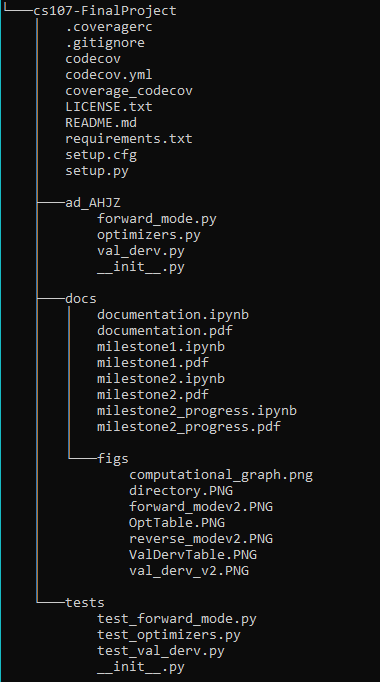


#### 2. __Modules:__

   * 2a. *val_derv.py*: This file contains the class definition of a value/derivative object. It contains methods to initialize the object, set and get the function and derivative value of the object, overload elementary operations, and define elementary functions. Specifically, we overload addition, multiplication, division, negation, power, reverse addition, reverse subtraction, reverse multiplication, reverse power, reverse division, equal, and not equal. Finally, we include elementary functions on these objects including 'sqrt', 'log', 'exp', 'sin', 'cos', 'tan', 'sinh', 'cosh', 'tanh', 'arcsin', 'arccos', 'arctan', and 'logistic'. This is not a file which the user will interact with.
   
   
   * 2b. *forward_mode.py*: This file contains the class definition to perform forward mode automatic differentiation. This is the module which the user will interact with to compute function values and derivatives using the forward mode object. Specifically, the user will create forward mode objects using the point or vector at which to evaluate the function(s), the function(s) they are interested in computing the derivative of, and the optional seed vector (default value is 1). Next, after initialization, they can make use of *get_function_value()* to retrieve function values, *get_jacobian()* to retrieve derivative values, and *get_function_value_jacobian()* to retrieve both the function and derivative values. 
   
   
   * 2c. *init.py*:  This file contains information relevant to how each of the modules associated with our package ad-AHJZ interact with one another. 
   
   
   * 2d. *optimizers.py*: This file contains the class definition to allow the users to utilize six optimization methods: Momentum, ADAM, NADAM, RMSprop, Broyden, and BFGS. Specifically, the user will be able to employ any of these six techniques to find the minimum value of an inputed function, the location of the minimum value, and the time needed to find the minimum. To perform the optimization, after selecting a specific method, a user must input the inital x value (scalar or vector), the function of interest (scalar), and the number of iterations (integer). Each method also contains optional hyperparameters to input, however we have set the default values to the accepted standard values. 
   
   
#### 3. __Test Suite Location:__
   * 3a. The test suite live in the "testing" directory which is a subdirectory found off the root directory (see 1. Directory Structure). The "testing" directory contains all unit tests and integration tests.
   
   
   * 3b. Our testing suite is built using Python's unittest framework. We have three files for testing, which are *test_val_derv.py*, *test_forward_mode.py*, and *test_optimizers.py*. The first file tests inputs for *val_derv.py* to ensure all overloaded operations and elementary functions are implemented correctly, the second file tests *forward_mode.py* to ensure the automatic differentiation is performed correctly in terms of computing function values and derivatives for both scalar and vector inputs/outputs, and the third file tests the optimization methods to ensure they accurately result the analytical minimum values of functions. We run our tests by running "coverage run  -m unittest discover -s tests/" in the root directory. 
    
    
   * 3c. To ensure our testing procedure has complete code coverage, we leverage CodeCov. CodeCov enables us to quickly understand which lines are being executed in our test cases. We directly upload our coverage reports to CodeCov through the use of a bash script and the .coveragerc, codecov, and codecov.yml files.
    
#### 4. __Package Distribution and Installation:__
   * 4a. Our package is distributed via PyPI. We have uploaded the package to PyPI using the setup.py and setup.cfg files which contain relevant information about our package as well as the version number, associated dependencies, and the license.  
   
   
   * 4b. A user can install our package from PyPI by creating a virtual environment as shown in _Installing the package_ in __How to Use ad-AHJZ__. Once a virtual environment has been created, the user can install our package by running the following line: 
   
``` bash
python3 -m pip install ad-AHJZ
```
* 4c: After installing our package, a user can import it into their desired python file and use it by including the following three lines at the top of their file: 

```python
from ad_AHJZ.forward_mode import forward_mode
from ad_AHJZ.optimizers import Optimizer
import numpy as np
```

* 4d: Developers and consumers should follow a different installation procedure. Namely, we expect developers to install our package via GitHub, specifically if they are interested in customizing the optimization methods to fine-tune them to their specific application/needs. Moreover, developers can contribute to our package via GitHub by making meaningful pull requests to enhance our package, which we hope to actively review. On the other hand, consumers should simply install our package via PyPI as outlined in 4b. above. This approach will enable a broad range of consumers to make use of our package without requiring a deep understanding of the methodology behind automatic differentiation and optimization.

#### 5. __Package Dependencies__
   * 5a. The only library dependency our package relies on is numpy. We designed our software in this manner to ensure that we are not creating multiple external dependencies and thereby increase our software's reliability.

# Implementation

#### 1.  __Core Data Structure:__
  * 1a. Our primary core data structure is the numpy array, which we use to store both the variable list and the function list. Then using the methods within the *forward_method* class we compute the jacobian and function value storing those values or arrays, depending on the input, in a tuple.      
      
      
#### 2.  __Classes:__

* 2a. *Val Derv:* The class that creates our *val_derv* object. This object has two attributes: the value and the derivative seed, which can be defined at instantiation. This object will be used with the elementary function methods to calculate the value, and the dual number at a particular state of the primal or tangent trace. 


* 2b. *Forward Mode:* The class that creates a *forward_mode* object. This object has two required attributes: the variable list and the function list, which can be defined at instantiation, and one optional attribute: the seed vector, which has a default value of 1. All three attributes can be in either scalar or vector form, and will be used to find either the function value, the jacobian, or both.     


* 2c. *Optimizer* (extension module): The class that creates an *optimizer* object. This object has no attributes, but each method within the class requires an x input, a function input, and the number of iterations for the specific optimizing method. Additionally, each method has their own optional hyperparameters which the user can input if they choose not to use our standard default values.


#### 3.  __Methods:__
* 3a. *Val Derv* Methods: Below we include a list of all methods in our *Val Derv* class along with their description:

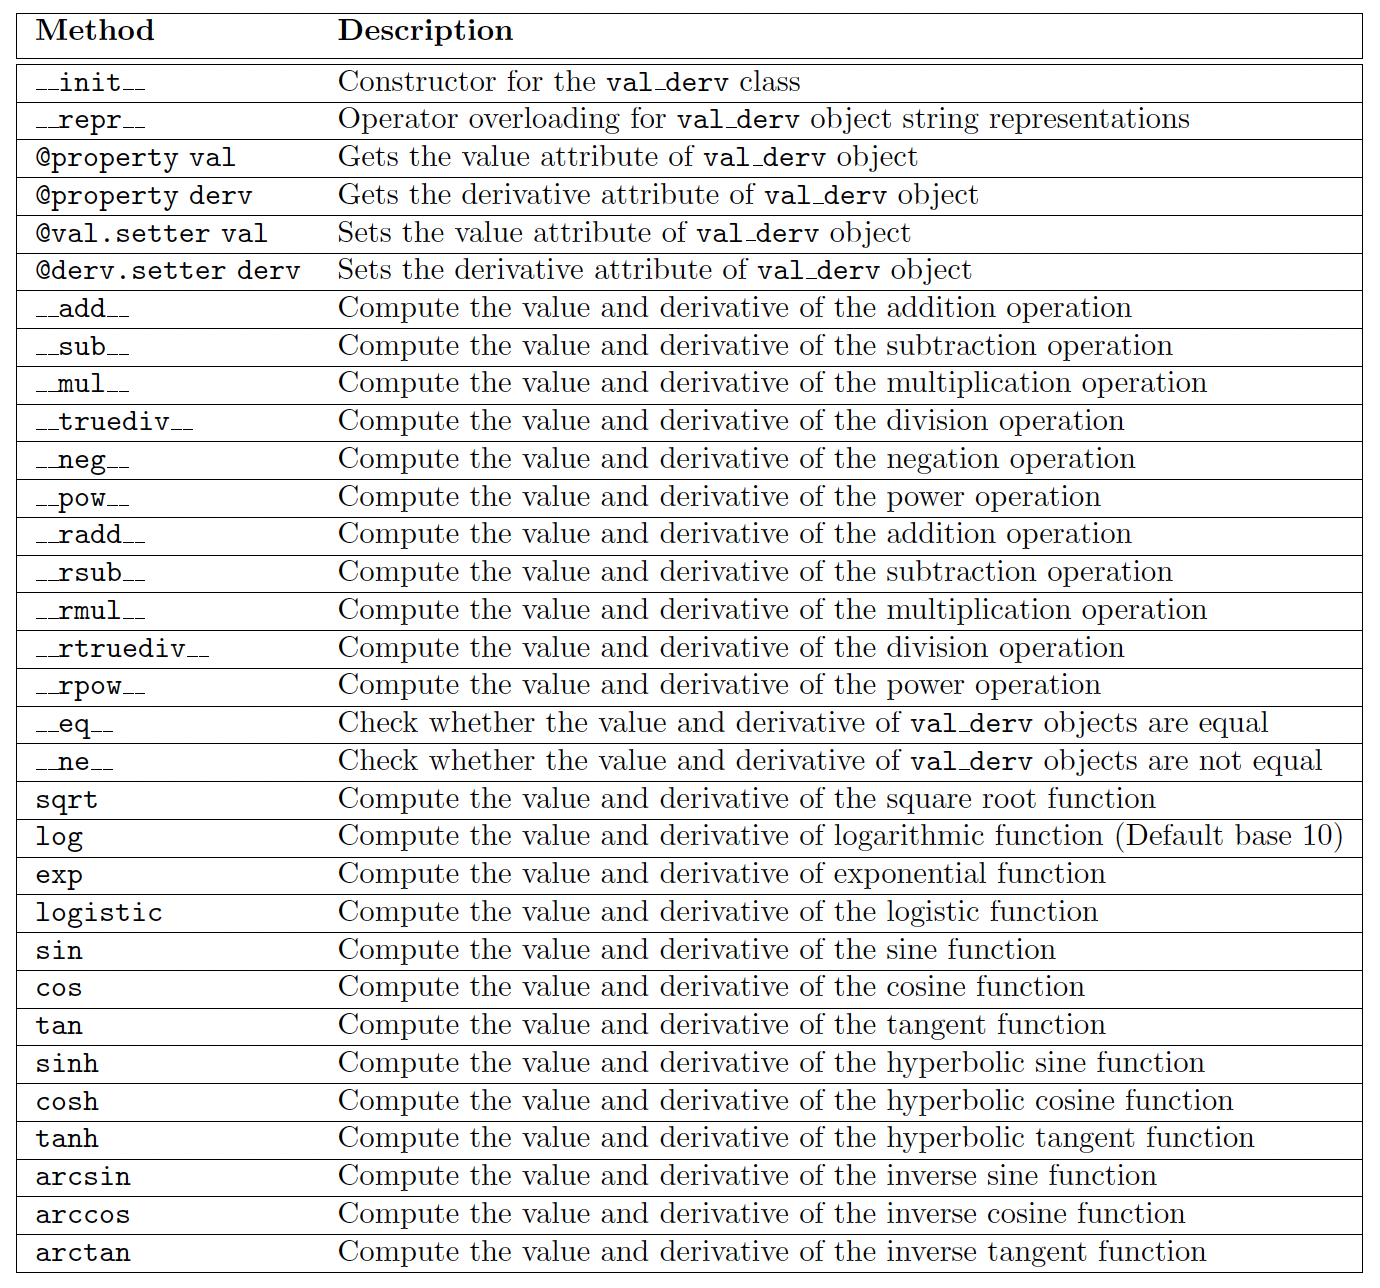

* 3b. *Forward Mode* Methods: Below we include a list of all methods in our *Forward Mode* class along with their description:

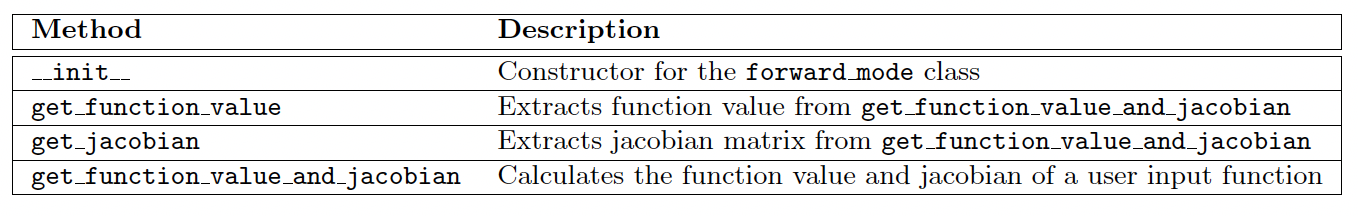

* 3c. *Optimizer* Methods: Below we include a list of all the optimization methods that we include in our *Optimizer* class along with their description:

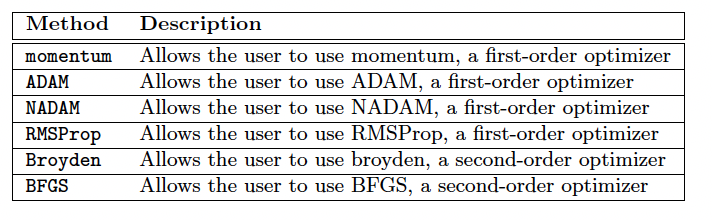

   
#### 4. __External Dependencies:__
* 4a. To be viewed as a near stand alone software package, to improve adoption, and increase efficiency, we chose to only employ a single external library, numpy. We’ve used the numpy library to create our data structure for the computational graph and perform computations outside of those we created in our *val_derv* class. 
    
    
#### 5.  __Dealing With Elementary Functions__
* 5a. As listed above, within the *val_derv* class we’ve overloaded the simple arithmetic functions (addition, subtraction, multiplication, division, negation, power, equal, and not equal) to calculate both the value and the dual number. We’ve also defined our own elementary functions, such as sin(x) and sqrt(x) (see __Methods__ above for full list) to compute the value and the derivative. This module generalizes each of the functions in order for the *forward_mode* class to handle both scalar and vector inputs. Each method also indicates errors specific to the types of possible invalid inputs. The output is a tuple of both the function value and the derivative, which is used in the *forward_mode* class.  


* 5b. Below are examples of how the user would implement *sin* and *sqrt*, both of which work with scalar or vector input values, within the *val_derv* class: 

```python  
# sqrt of variable with scalar derivative
x = val_derv(1, 1)
print(x.sqrt())
>>>Values:1.0, Derivatives:0.5
```
```python 
# sqrt of variable with vector derivative
x = val_derv(1, np.array([1, 0]))
print(x.sqrt())
>>>Values:1.0, Derivatives:[0.5 0. ]
``` 
```python 
# sin of variable with scalar derivative
x = val_derv(0, 1)
print(x.sin())
>>>Values:0.0, Derivatives:1.0

``` 
```python
# sin of variable with vector derivative
x = val_derv(0, np.array([1, 0]))
print(x.sin())
>>> Values:0.0, Derivatives:[1. 0.]
```

# Broad Overview of Optimization Methods (Extension)

Below, we include an overview of our extension module: optimization methods. We detail the math and theory behind each optimizer in the Background section and the structure of the code in the Software Organization and Implementation sections earlier. In summary, we have implemented six different optimization methods, which include both first and second order methods.

Please see **Background**, **Software Organization**, and **Implementation** sections for further detail. 

The six methods are the following: 

* 1. *Optimizers.momentum(x, f_x, num_iter, alpha=0.01, beta=.9)* - Momentum is an optimization method that helps accelerate gradient vectors in the right directions and overcome the oscillations of noisy gradients in order to achieve faster convergence. 

    * The required inputs for this optimizer are x, f_x, and num_iter, where x is either a scalar or a vector input, f_x is the function that the user would like to find the minima for, and num_iter is the maximum number of iterations the user would like to set. 
    
    * The optional arguments are alpha and beta, and their default values are: alpha=0.01 and beta=.9. To understand how each of these optional arguments, also known as hyperparameters, function please see Background/Optimization Techniques/ Part 1: Momentum.


* 2. *Optimizers.ADAM(x, f_x, num_iter, alpha=0.01, beta1=.9, beta2=.999, epsilon=1e-8)* - Adam (short for Adaptive Moment Estimation) is an optimization method that computes adaptive learning rates for each parameter. 

    * The required inputs for this optimizer are x, f_x, and num_iter, where x is either a scalar or a vector input, f_x is the function that the user would like to find the minima for, and num_iter is the maximum number of iterations the user would like to set. 
    
    * The optional arguments are alpha, beta1, beta2, and epsilon, and their default values are: alpha=0.01, beta1=.9, beta2=.999, and epsilon=1e-8. To understand how each of these optional arguments, also known as hyperparameters, function please see Background/Optimization Techniques/ Part 2: ADAM.


* 3. *Optimizers.NADAM(x, f_x, num_iter, alpha=0.01, beta1=.9, beta2=.999, epsilon=1e-8)* - Nadam (short for Nesterov-accelerated Adaptive Moment Estimation) is an optimization method that combines Adam and another popular optimizer, NAG. 

    * The required inputs for this optimizer are x, f_x, and num_iter, where x is either a scalar or a vector input, f_x is the function that the user would like to find the minima for, and num_iter is the maximum number of iterations the user would like to set. 
    
    * The optional arguments are alpha, beta1, beta2, and epsilon, and their default values are: alpha=0.01, beta1=.9, beta2=.999, and epsilon=1e-8. To understand how each of these optional arguments, also known as hyperparameters, function please see Background/Optimization Techniques/ Part 3: NADAM.


* 4. *Optimizers.RMSprop(x, f_x, num_iter, alpha=0.01, beta=.9, epsilon=1e-8)* - RMSprop (short for Root Mean Squared Propogation) is another gradient descent optimization algorithm that uses a decaying average of partial gradients in the adaptation of the step size for each parameter. 

    * The required inputs for this optimizer are x, f_x, and num_iter, where x is either a scalar or a vector input, f_x is the function that the user would like to find the minima for, and num_iter is the maximum number of iterations the user would like to set. 
    
    * The optional arguments are alpha, beta, and epsilon, and their default values are: alpha=0.01, beta1=.9, and epsilon=1e-8. To understand how each of these optional arguments, also known as hyperparameters, function please see Background/Optimization Techniques/ Part 4: RMSProp.


* 5. *Optimizers.broyden(x, f_x, num_iter, alpha=0.01)* - Broyden's method is a secant method for solving systems of nonlinear equations. The key feature of Broyden's method is its ability to generate a reasonable approximation to the Jacobian matrix with no additional evaluations of the function. 

    * The required inputs for this optimizer are x, f_x, and num_iter, where x is either a scalar or a vector input, f_x is the function that the user would like to find the minima for, and num_iter is the maximum number of iterations the user would like to set. 
    
    * The optional argument is alpha, and it has a default value of 0.01. To understand how this optional argument, also known as a hyperparameter, functions please see Background/Optimization Techniques/ Part 5: Broyden.


* 6. *Optimizers.BFGS(x, f_x, num_iter, alpha=0.01)* - BFGS (short for Bryoden, Fletcher, Goldfarb, and Shanno) is an iterative second order optimization algorithm that determines the descent direction by preconditioning the gradient with curvature information. This is done by gradually improving an approximation to the Hessian matrix of the loss function, which is obtained via gradient evaluations using a generalized secant method. 

    * The required inputs for this optimizer are x, f_x, and num_iter, where x is either a scalar or a vector input, f_x is the function that the user would like to find the minima for, and num_iter is the maximum number of iterations the user would like to set. 
    
    * The optional argument is alpha, and it has a default value of 0.01. To understand how this optional argument, also known as a hyperparameter, functions please see Background/Optimization Techniques/ Part 6: BFGS.


Our extension module contains the class definition to allow the users to utilize these six optimization methods. Specifically, the user is able to employ any of these six techniques to find the minimum value of an inputed function, the location of the minimum value, and the time needed to find the minimum. To perform the optimization, after selecting a specific method, a user must input the initial x value (scalar or vector), the function of interest (scalar), and the number of iterations (integer). Each method also contains optional hyperparameters to input as shown above, however we have set the default values to the accepted standard values.

# Broader Impact and Inclusivity Statement

### Broader Impact

Automatic differentiation is used across a plethora of different applications and it is this ubiquity and generalizability that leads it to have broad impact and consequential implications. For instance, in business, automatic differentiation is essential in analyzing the profit and loss for a company or finding the minimum amount of material that is needed to construct a new building. In physics, automatic differentiation can be used to effectively calculate the speed and distance of a moving object. In machine learning, automatic differentiation can be used via optimization techniques in order to efficiently train algorithms. With such varied applications, it becomes evident that automatic differentiation is a significant tool across many domains. 


With these many use cases, automatic differentiation certainly has positive implications on society as a whole, but it can also lead to negative consequences.  Unfortunately, automatic differentiation can be used by ill-willed or malicious companies that aim to prioritize profit over societal good. For instance, digital advertising revenues are primarily driven by collecting personal, user data and then using this data to deliberately target unsuspecting users into purchasing certain products or services. Large technology companies hence make use of automatic differentiation to create optimization techniques that are used to iteratively train robust machine learning algorithms. These algorithms can then learn an excessive amount of information about a company’s consumers. In this regard, automatic differentiation is being used to take advantage of individuals’ data and sacrifice the privacy of innocent users. As another key example of misuse, automatic differentiation is used by physicists to test and enhance weapons in order to optimize launch times and measure maximum launch heights. While the use of this method can enable such scientists to effectively and efficiently complete their calculations, their results are being used to create weapons of mass destruction that can impact millions of lives and leave permanent physical damage to the Earth and its environment.


With these impacts and implications in mind, we urge the users of our library to proceed with caution. We have designed our code in a way to enable generalizability and usefulness across a wide range of applications, however we urge developers to be aware and careful when working with automatic differentiation. While much good can be brought to society through the use of our library, an equal amount of harm can also result through careless or inconsiderate use cases. To prevent the latter, it is important that all users understand the theory and practical purpose of automatic differentiation, some of its many use cases, and its approach to computing derivatives. We outline all of these matters in our library documentation. 

### Inclusivity 

To make our package as inclusive as possible to the broader community, we have distributed it on PyPI. PyPI allows anyone with access to a computer with internet connectivity to download our package for free. In order to further increase accessibility, we plan on making our GitHub repository public so that we can enable our package to be accessible to a broader community that can make code contributions.


Our second step towards increasing accessibility and inclusivity of our package is through our documentation and code comments. We have written all our documentation and comments in standard English, which is the primary medium of communication for the core code contributors. We avoided the use of abbreviations, slang terms, and unclear language to ensure that our text does not become a barrier to inclusivity. If our package is expanded further in the future, we hope to provide support for a few other primary languages such as Spanish and French. For all other languages, we hope users will be able to make use of well-known translators such as Google Translate. 


Our third step towards inclusivity pertains to open-sourceness. Our software is open source and this enables anyone to create a pull request and hence share their thoughts and code pertaining to the direction our package should take as it evolves. We make a commitment to evaluate any pull requests “blindly”. In other words, we will not use a GitHub user’s username, gender, legal name, nick-name or any other personal information to evaluate a pull request. This approach ensures that we are avoiding any discrimination and are purely evaluating requests based on their code quality. 

# Future Features

One capability we would like to implement in the future is reverse mode automatic differentiation. We would like to create a class analogous to forward mode, but which instead simulates reverse mode. Compared to forward mode, reverse mode would yield a significantly smaller arithmetic operation count for mappings of the form $f(x): R^{n} \rightarrow R^{m}$ when $n >> m$.  We hope that offering a reverse mode class in the future would enable users to tackle large-scale machine learning tasks, which would require efficient and reliable differentiation.


Another capability we would like to offer in the future is a visualization tool for forward mode. More specifically, we would like to create an option for users to view an animation pane that pops up, showing the full trace of forward mode based on the input function and value/vector to evaluate. This would be tremendously useful not only for teaching purposes, but also for new users of our library that are not as familiar with automatic differentiation.


A third extension we would like to add to our code is an accompanying GUI. Currently, our package is accessible by those who understand how to read and write code. However, we hope that creating a GUI that can be opened up in a web browser would enable individuals from non-computational domains such as biology, genetics, and health science to use our package and leverage its computational efficiency benefits. 


Finally, we hope to expand our class of optimizers currently implemented. We offer six different optimization options which provide users with a great starting point to use in their machine learning scripts to train models. However, we hope to expand our offerings of optimizers to include even more sophisticated techniques such as conjugate gradients.

# Licensing

Our _ad-AHJZ_ package is licensed under the GNU General Public License v3.0. This free software license allows users to do just about anything they want with our project, except distribute closed source versions. This means that any improved versions of our package that individuals seek to release must also be free software. We find it essential to allow users to help each other share their bug fixes and improvements with other users. Our hope is that users of this package continually find ways to improve it and share these improvements within the broader scientific community that uses automatic differentiation.